In [1]:
import os
import subprocess
import time
import pickle

import numpy as np

from matplotlib import pyplot as plt

import random
%matplotlib inline

In [2]:
import cv2

In [3]:
class Env:
    def __init__(self):
        self.restart_btn_img = cv2.imread('./restart_button.png', cv2.IMREAD_GRAYSCALE)
        self.action_space = range(20)
        self.dist_space = np.linspace(300, 1000, len(self.action_space))
    
    def __jump(self, distance):
        subprocess.call(".\\adb\\adb shell input swipe 500 500 500 500 %d" % distance)
        time.sleep(distance / 1000 + 2)
        
        
    def __capture_img(self, filename):
        subprocess.call('.\\adb\\adb shell /system/bin/screencap -p /sdcard/screenshot.png')
        time.sleep(0.1)
        subprocess.call('.\\adb\\adb pull /sdcard/screenshot.png %s' % filename)
        time.sleep(0.1)

        
    def __find_restart_btn(self, screen_shot_im):
        result = cv2.matchTemplate(screen_shot_im,
                                   self.restart_btn_img,
                                   cv2.TM_CCOEFF_NORMED)
        if result.max() > 0.8:
            y,x = np.unravel_index(result.argmax(),result.shape)
            y += self.restart_btn_img.shape[0] // 2
            x += self.restart_btn_img.shape[1] // 2
            return x, y
        else:
            return -1, -1
        
    def __to_state(self, screen_shot_im):
        return np.expand_dims(cv2.resize(screen_shot_im, (120, 200)) / 255.0,-1)
    
    
    def dist(self, action):
        d = action * 400 + 700
        if d < 300:
            d = 300
        elif d > 1100:
            d = 1100
            
        return d
        
        
    def reset(self):
        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            # Kill self
            self.__jump(1500)
            self.__capture_img('./tmp/screenshot.png')
            im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
            btn_x, btn_y = self.__find_restart_btn(im)
            
            assert btn_x != -1
                
        subprocess.call('.\\adb\\adb shell input tap %d %d' % (btn_x, btn_y))
        time.sleep(0.5)

        self.__capture_img('./tmp/screenshot.png')
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        btn_x, btn_y = self.__find_restart_btn(im)

        assert btn_x == -1
        
        return self.__to_state(im)
        
        
    def step(self, action):
        '''
        action: touch time(milliseconds)
        return: 
        '''
        time.sleep(0.5)
        
        dist = self.dist(action)
        self.__jump(dist)
        
        self.__capture_img('./tmp/screenshot.png')
        
        im = cv2.imread('./tmp/screenshot.png', cv2.IMREAD_GRAYSCALE)
        
        btn_x, btn_y = self.__find_restart_btn(im)
        
        # The game has not ended yet
        if btn_x == -1:
            state = self.__to_state(im)
            reward = 1
            done = False
            return state, reward, done
        else:
            state = None
            reward = -1
            done = True
            return state, reward, done
        

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14846900086831288699
]


In [5]:
from keras.layers import *
from keras.models import Model,load_model,Sequential
from keras.callbacks import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.applications.resnet50 import identity_block, conv_block

Using TensorFlow backend.


In [6]:
import tensorflow as tf

In [7]:
class ActorNetwork(object):
    def __init__(self, sess, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        K.set_session(sess)

        #Now create the model
        self.model , self.weights, self.state = self.create_actor_network()   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network() 
        self.action_gradient = tf.placeholder(tf.float32,[None, 1])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)
        self.sess.run(tf.initialize_all_variables())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self):
        inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(inputs)
        
        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(16, (8, 8), strides=(4,4), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)

        outputs = Dense(1, activation='tanh')(x)
        model = Model(inputs, outputs)
        model.compile(loss='mean_squared_error', optimizer=Nadam(lr=self.LEARNING_RATE))

        return model, model.trainable_weights, inputs

In [8]:
class CriticNetwork(object):
    def __init__(self, sess, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        
        K.set_session(sess)

        #Now create the model
        self.model, self.state, self.action = self.create_critic_network()  
        self.target_model, self.target_state, self.target_action = self.create_critic_network()  
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        self.sess.run(tf.initialize_all_variables())

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        state_inputs = Input(shape=(200,120,1))
        
        def Slice():
            def func(x):
                return x[:,50:170,:,:] - 0.5
            return Lambda(func)
        
        x = Slice()(state_inputs)
        
        x = AveragePooling2D((3,3),strides=(2,2), padding='same')(x)

        x = Conv2D(16, (8, 8), strides=(4,4), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Conv2D(32, (4, 4), strides=(2,2), padding='same')(x)
        x = Activation('relu')(x)
        
        x = Flatten()(x)
        x_s = Dense(256, activation='relu')(x)
        
        action_inputs = Input(shape=(1,))
        x_a = Dense(256, activation='relu')(action_inputs)
        
#         x = Add()([x_s,x_a])

#         x_a = Dense(128, activation='relu')(action_inputs)
        
        x = Concatenate()([x_s,x_a])
        x = Dense(512)(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        outputs = Dense(1, activation='linear')(x)
        
        model = Model([state_inputs, action_inputs], outputs)
        model.compile(loss='mean_squared_error', optimizer=Nadam(lr=self.LEARNING_RATE))
 
        return model, state_inputs, action_inputs 

In [9]:
class OU(object):

    def function(self, x, mu, theta, sigma):
        return theta * (mu - x) + sigma * np.random.randn(1)[0]
    
OU = OU()

In [10]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.memory = []
        
        self.GAMMA = 0.99
        self.TAU = 1     #Target Network HyperParameters
        self.LRA = 0.0001    #Learning rate for Actor
        self.LRC = 0.001     #Lerning rate for Critic

        self.episode_count = 2000
        self.max_steps = 100000
        self.reward = 0
        self.done = False
        self.step = 0
        self.epsilon = 1
        self.epsilon_decay = .99
        self.epsilon_min = 0.1
        self.indicator = 0

        #Tensorflow GPU optimization
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        K.set_session(self.sess)
        
        self.BATCH_SIZE = 32
        
        self.mem_len = 200

        self.actor = ActorNetwork(self.sess, self.BATCH_SIZE, self.TAU, self.LRA)
        self.critic = CriticNetwork(self.sess, self.BATCH_SIZE, self.TAU, self.LRC)
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    def act(self, state):
        act = self.actor.model.predict_on_batch(np.expand_dims(state,0))[0][0]
        
        noise = self.epsilon * OU.function(act, 0, 0.5, 0.5)
        
        print('act:',act,'noise:',noise,'sum:',act+noise)
        
        return act + noise
    
    
    def replay(self):
        if len(self.memory) < 64:
            self.mem_len = 32
        elif len(self.memory) < 128:
            self.mem_len = 64
        elif len(self.memory) < 256:
            self.mem_len = 128
        elif len(self.memory) < 512:
            self.mem_len = 256
        else:
            self.mem_len = 512
        
        mem = self.memory[-self.mem_len:]
        
        n_batch = min(self.BATCH_SIZE, len(mem))
        batches = np.random.choice(len(mem), n_batch)
        
        states = []
        actions = []
        rewards = []
        new_states = []
        dones = []
        
        for i,mem_idx in enumerate(batches):
            state, action, reward, next_state, done = mem[mem_idx]
            
            if done:
                next_state = np.zeros_like(state)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            new_states.append(next_state)
            dones.append(done)
        
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        new_states = np.array(new_states)

        target_q_values = self.critic.target_model.predict_on_batch(
            [new_states, self.actor.target_model.predict_on_batch(new_states)])
        
        y_t = []
        
        for k,d in enumerate(dones):
            if d:
                y_t.append(rewards[k])
            else:
                y_t.append(rewards[k] + self.GAMMA*target_q_values[k])
                
        y_t = np.array(y_t)
        
        loss = self.critic.model.train_on_batch([states,actions], y_t) 
        a_for_grad = self.actor.model.predict_on_batch(states)
        grads = self.critic.gradients(states, a_for_grad)
        self.actor.train(states, grads)
        self.actor.target_train()
        self.critic.target_train()
        
        return loss

In [11]:
episodes = 1000

# 为agent初始化gym环境参数
env = Env()

(array([  46.,   68.,   88.,  126.,  170.,  150.,  132.,  107.,   52.,   61.]),
 array([  300.,   380.,   460.,   540.,   620.,   700.,   780.,   860.,
          940.,  1020.,  1100.]),
 <a list of 10 Patch objects>)

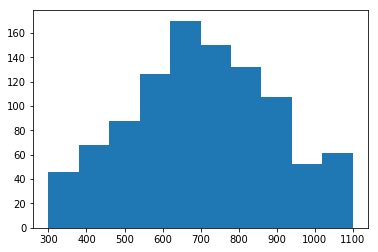

In [12]:
plt.hist([env.dist(i) for i in list(np.random.randn(1000) * 0.5)])

In [13]:
agent = Agent(env)
agent.actor.model.summary()
agent.critic.model.summary()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 120, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 120, 120, 1)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 16)        1040      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          8224      
_________________________________________________________________
ac

In [14]:
scores = []

In [19]:
# 游戏的主循环
for e in range(episodes):

    # 在每次游戏开始时复位状态参数
    state = env.reset()

    # time_t 代表游戏的每一帧
    # time_t 越大，分数越高
    
    loss = 0
    for time_t in range(10000):
        
        # turn this on if you want to render
        # env.render()

        # 选择行为
        action = agent.act(state)

        # 在环境中施加行为推动游戏进行
        next_state, reward, done = env.step(action)
        
        print('jump dist:', env.dist(action))

        # 记忆先前的状态，行为，回报与下一个状态
        agent.remember(state, action, reward, next_state, done)

        # 使下一个状态成为下一帧的新状态
        state = copy.deepcopy(next_state)
        
        loss += agent.replay()

        # 如果游戏结束done被置为ture
        # 除非agent没有完成目标
        if done:
            # 打印分数并且跳出游戏循环
            print("episode: {}/{}, score: {}"
                  .format(e, episodes, time_t))
            scores.append(time_t)
            break
    
    loss /= (time_t+1)
    
    print('mem:', len(agent.memory), 'epsilon:', agent.epsilon, 'loss:', loss)
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

act: -0.00679354 noise: -0.133821484502 sum: -0.14061502587
jump dist: 643.753989652
act: -0.0286678 noise: -0.236919601405 sum: -0.265587435061
jump dist: 593.765025976
episode: 0/1000, score: 1
mem: 218 epsilon: 0.4298890135238936 loss: 0.632618695498
act: 0.00822755 noise: -0.0380935452293 sum: -0.0298659966673
jump dist: 688.053601333
act: -0.00508947 noise: 0.0619165500356 sum: 0.0568270770563
jump dist: 722.730830823
act: -0.0247857 noise: -0.094633166403 sum: -0.119418828473
jump dist: 652.232468611
episode: 1/1000, score: 2
mem: 221 epsilon: 0.42559012338865465 loss: 0.633767147859
act: -0.0361133 noise: 0.227362625278 sum: 0.191249351925
jump dist: 776.49974077
act: -0.0506873 noise: 0.184728589904 sum: 0.134041254472
jump dist: 753.616501789
act: -0.0185666 noise: -0.0916648704551 sum: -0.110231488197
jump dist: 655.907404721
episode: 2/1000, score: 2
mem: 224 epsilon: 0.4213342221547681 loss: 0.60593833526
act: -0.0508429 noise: 0.141174433351 sum: 0.0903315111701
jump dist:

jump dist: 815.337335606
act: -0.183782 noise: 0.122726626696 sum: -0.0610549077371
jump dist: 675.578036905
episode: 23/1000, score: 1
mem: 292 epsilon: 0.34116606151404244 loss: 0.821956187487
act: 0.26753 noise: 0.0705441606592 sum: 0.338073827083
jump dist: 835.229530833
act: 0.0913652 noise: -0.100468518458 sum: -0.00910330774592
jump dist: 696.358676902
act: 0.0530541 noise: -0.0392948449776 sum: 0.0137592269853
jump dist: 705.503690794
episode: 24/1000, score: 2
mem: 295 epsilon: 0.337754400898902 loss: 1.08995165428
act: 0.469925 noise: 0.235886776288 sum: 0.705811673244
jump dist: 982.324669297
episode: 25/1000, score: 0
mem: 296 epsilon: 0.334376856889913 loss: 0.572390913963
act: 0.267183 noise: -0.090341913964 sum: 0.176840734218
jump dist: 770.736293687
act: 0.0972654 noise: 0.114462799056 sum: 0.211728169246
jump dist: 784.691267698
act: -0.199706 noise: -0.0862935262849 sum: -0.285999752872
jump dist: 585.600098851
act: -0.273883 noise: 0.0707401829292 sum: -0.2031432790

jump dist: 629.491005865
act: 0.133962 noise: -0.109351159795 sum: 0.0246107710764
jump dist: 709.844308431
act: -0.464522 noise: 0.147509635793 sum: -0.317012040509
jump dist: 573.195183796
act: -0.100764 noise: 0.237135201052 sum: 0.136371306435
jump dist: 754.548522574
episode: 40/1000, score: 6
mem: 375 epsilon: 0.28758360936686406 loss: 1.48942031179
act: 0.053347 noise: -0.144858194243 sum: -0.0915111766269
jump dist: 663.395529349
act: 0.131248 noise: -0.288069277398 sum: -0.156820982091
jump dist: 637.271607164
act: -0.42298 noise: 0.302844322195 sum: -0.120136165151
jump dist: 651.945533939
episode: 41/1000, score: 2
mem: 378 epsilon: 0.2847077732731954 loss: 2.20298906167
act: -0.0535128 noise: 0.258195774692 sum: 0.204682996558
jump dist: 781.873198623
act: 0.0583257 noise: 0.0140285651446 sum: 0.0723542507053
jump dist: 728.941700282
act: -0.105666 noise: -0.0885513448478 sum: -0.194217468178
jump dist: 622.313012729
episode: 42/1000, score: 2
mem: 381 epsilon: 0.2818606955

jump dist: 597.10780041
act: -0.734902 noise: 0.090097565022 sum: -0.644804220829
jump dist: 442.078311669
act: -0.723557 noise: 0.188916101163 sum: -0.534640417391
jump dist: 486.143833043
act: -0.444602 noise: 0.146468128897 sum: -0.298133615516
jump dist: 580.746553794
act: -0.323399 noise: -0.0765429704429 sum: -0.399941649938
jump dist: 540.023340025
episode: 52/1000, score: 14
mem: 463 epsilon: 0.2549097606963092 loss: 2.35333990256
act: 0.0340284 noise: 0.275552960532 sum: 0.309581378894
jump dist: 823.832551558
act: 0.47243 noise: -0.0917614214273 sum: 0.380668360725
jump dist: 852.26734429
act: -0.567727 noise: 0.309599062333 sum: -0.258128384224
jump dist: 596.748646311
act: 0.3969 noise: 0.0408551746262 sum: 0.437755560244
jump dist: 875.102224098
act: -0.702415 noise: 0.101710036301 sum: -0.600704833961
jump dist: 459.718066416
act: -0.439921 noise: 0.103075170604 sum: -0.336845582637
jump dist: 565.261766945
act: -0.571053 noise: 0.0544112041207 sum: -0.516641704777
jump d

act: 0.216918 noise: -0.0577260558493 sum: 0.159192397725
jump dist: 763.67695909
act: -0.449738 noise: 0.173647230815 sum: -0.276091212083
jump dist: 589.563515167
act: -0.0656645 noise: 0.123970415085 sum: 0.0583059076367
jump dist: 723.322363055
act: -0.308501 noise: -0.100619395649 sum: -0.409120192206
jump dist: 536.351923118
act: 0.245431 noise: -0.051535805098 sum: 0.193895409473
jump dist: 777.558163789
act: -0.00570848 noise: -0.106627758227 sum: -0.11233623429
jump dist: 655.065506284
act: -0.179457 noise: 0.0772942422041 sum: -0.102163079559
jump dist: 659.134768176
act: 0.112233 noise: 0.0258268102948 sum: 0.138060307497
jump dist: 755.224122999
act: -0.328933 noise: -0.0921571367509 sum: -0.42109058435
jump dist: 531.56376626
act: 0.095159 noise: 0.283078936545 sum: 0.378237960546
jump dist: 851.295184218
act: 0.171801 noise: -0.131970814738 sum: 0.0398304394154
jump dist: 715.932175766
act: 0.487032 noise: 0.0162589856581 sum: 0.503291101118
jump dist: 901.316440447
act: 

jump dist: 665.172126996
episode: 71/1000, score: 10
mem: 638 epsilon: 0.21059844619672854 loss: 4.94017423283
act: 0.105853 noise: -0.0958857913786 sum: 0.00996737132726
jump dist: 703.986948531
act: 0.321246 noise: 0.104881121859 sum: 0.426126643166
jump dist: 870.450657266
act: -0.423094 noise: 0.117246505754 sum: -0.30584764765
jump dist: 577.66094094
act: 0.288316 noise: -0.0577920381473 sum: 0.230524152095
jump dist: 792.209660838
act: 0.130832 noise: 0.225334180978 sum: 0.356166420963
jump dist: 842.466568385
act: 0.0932553 noise: -0.0775602256397 sum: 0.0156950930615
jump dist: 706.278037225
act: -0.168975 noise: -0.0254093115269 sum: -0.19438444125
jump dist: 622.2462235
act: -0.16676 noise: 0.183205356358 sum: 0.0164452395424
jump dist: 706.578095817
episode: 72/1000, score: 7
mem: 646 epsilon: 0.20849246173476127 loss: 5.76818352938
act: 0.170345 noise: -0.0849646075857 sum: 0.0853802517759
jump dist: 734.15210071
act: 0.242953 noise: -0.0567622032881 sum: 0.18619073956
jump

jump dist: 601.748172431
act: 0.21168 noise: 0.0949268721588 sum: 0.306606449986
jump dist: 822.642579995
act: 0.512401 noise: -0.0137780593995 sum: 0.498622567737
jump dist: 899.449027095
act: 0.133353 noise: -0.00793050452019 sum: 0.125422669213
jump dist: 750.169067685
act: -0.363953 noise: -0.0334553831455 sum: -0.397408556306
jump dist: 541.036577478
act: -0.194403 noise: -0.0306183443539 sum: -0.225021188068
jump dist: 609.991524773
act: 0.394132 noise: 0.147901434536 sum: 0.542033005591
jump dist: 916.813202236
act: -0.093375 noise: -0.14864845387 sum: -0.242023451247
jump dist: 603.190619501
act: 0.501558 noise: 0.0420022558254 sum: 0.543560738472
jump dist: 917.424295389
act: 0.00642317 noise: -0.0798706830956 sum: -0.0734475124173
jump dist: 670.620995033
act: 0.0638863 noise: -0.20090501111 sum: -0.137018756084
jump dist: 645.192497566
act: 0.556664 noise: -0.183790039048 sum: 0.37287353374
jump dist: 849.149413496
act: -0.689701 noise: 0.0690148460134 sum: -0.620686472727
j

jump dist: 717.533805668
act: -0.660899 noise: 0.0553268264857 sum: -0.605572037784
jump dist: 457.771184887
act: 0.170135 noise: 0.111918333056 sum: 0.282052907231
jump dist: 812.821162893
act: 0.573414 noise: -0.127718196126 sum: 0.445695414332
jump dist: 878.278165733
act: -0.0361617 noise: -0.136810501799 sum: -0.1729722002
jump dist: 630.81111992
act: -0.222514 noise: 0.0190872216755 sum: -0.20342703516
jump dist: 618.629185936
act: 0.138638 noise: -0.0666252691354 sum: 0.0720129888449
jump dist: 728.805195538
act: 0.152304 noise: 0.0499398193517 sum: 0.202243500129
jump dist: 780.897400052
act: 0.409704 noise: -0.00402538194744 sum: 0.40567823038
jump dist: 862.271292152
act: -0.800599 noise: -0.100007292972 sum: -0.900606391178
jump dist: 339.757443529
act: -0.804518 noise: 0.0900319442567 sum: -0.714485920924
jump dist: 414.20563163
episode: 84/1000, score: 49
mem: 833 epsilon: 0.18480456394854633 loss: 21.2149361992
act: 0.0172457 noise: -0.115518576446 sum: -0.0982728497859
j

jump dist: 606.495569767
act: 0.0331268 noise: -0.150263075602 sum: -0.117136229646
jump dist: 653.145508142
act: -0.0206692 noise: -0.096262694273 sum: -0.11693193664
jump dist: 653.227225344
act: 0.490478 noise: 0.0204108337905 sum: 0.510888812974
jump dist: 904.355525189
act: 0.352044 noise: 0.0915494882755 sum: 0.443593474596
jump dist: 877.437389838
act: 0.368906 noise: -0.0544041278919 sum: 0.314501386587
jump dist: 825.800554635
act: -0.154825 noise: 0.092971040675 sum: -0.0618544083149
jump dist: 675.258236674
act: -0.691286 noise: 0.219352135406 sum: -0.471934309258
jump dist: 511.226276297
episode: 95/1000, score: 8
mem: 918 epsilon: 0.16546259566473479 loss: 14.5418142213
act: 0.0549606 noise: 0.0529512621796 sum: 0.107911822233
jump dist: 743.164728893
act: -0.107921 noise: 0.00767088186758 sum: -0.100249682844
jump dist: 659.900126863
act: -0.279826 noise: 0.0638093972554 sum: -0.216017005409
jump dist: 613.593197836
act: 0.518212 noise: -0.0469797917073 sum: 0.47123228829

act: 0.337243 noise: -0.0404415024078 sum: 0.296801249906
jump dist: 818.720499962
act: -0.307366 noise: 0.0530474323188 sum: -0.254318879231
jump dist: 598.272448307
act: 0.0403418 noise: 0.0889754734436 sum: 0.129317256759
jump dist: 751.726902703
act: 0.337829 noise: 0.124361365016 sum: 0.46219006079
jump dist: 884.876024316
act: -0.328746 noise: 0.0629149561559 sum: -0.26583070701
jump dist: 593.667717196
episode: 99/1000, score: 19
mem: 1010 epsilon: 0.15894270919978754 loss: 15.3930849552
act: 0.0915286 noise: 0.0853772382644 sum: 0.176905825308
jump dist: 770.762330123
act: 0.163401 noise: -0.047140775657 sum: 0.116259978676
jump dist: 746.50399147
act: -0.471191 noise: -0.13246341046 sum: -0.603654190862
jump dist: 458.538323655
episode: 100/1000, score: 2
mem: 1013 epsilon: 0.15735328210778965 loss: 11.7796487808
act: 0.0394924 noise: -0.0646182757653 sum: -0.0251258549131
jump dist: 689.949658035
act: 0.422333 noise: 0.019975046557 sum: 0.442308287066
jump dist: 876.923314826

jump dist: 519.690205681
act: -0.0192549 noise: -0.110945367851 sum: -0.130200277679
jump dist: 647.919888928
act: -0.0963 noise: -0.179100792084 sum: -0.275400790546
jump dist: 589.839683782
act: 0.0208544 noise: -0.0502432510241 sum: -0.0293888803556
jump dist: 688.244447858
act: -0.220154 noise: -0.0257183469113 sum: -0.245872706848
jump dist: 601.650917261
act: -0.0788153 noise: 0.0748781941639 sum: -0.00393710212844
jump dist: 698.425159149
act: 0.243561 noise: 0.093542362217 sum: 0.337103227738
jump dist: 834.841291095
act: 0.385675 noise: -0.13263506408 sum: 0.25303962116
jump dist: 801.215848464
act: -0.416342 noise: 0.0694520553171 sum: -0.346889666695
jump dist: 561.244133322
act: 0.130102 noise: -0.0657361262037 sum: 0.0643657184647
jump dist: 725.746287386
act: -0.707013 noise: 0.177565342418 sum: -0.529447251328
jump dist: 488.221099469
act: -0.174664 noise: 0.00597423268859 sum: -0.168690190181
jump dist: 632.523923928
act: -0.381058 noise: -0.0718490387638 sum: -0.452907

KeyboardInterrupt: 

In [20]:
pickle.dump(agent.memory,open('./tmp/ddpg_mem.m','wb'))

In [24]:
agent.actor.model.save_weights('./tmp/ddpg_actor.w')
agent.actor.target_model.save_weights('./tmp/ddpg_tactor.w')
agent.critic.model.save_weights('./tmp/ddpg_critic.w')
agent.critic.target_model.save_weights('./tmp/ddpg_tcritic.w')

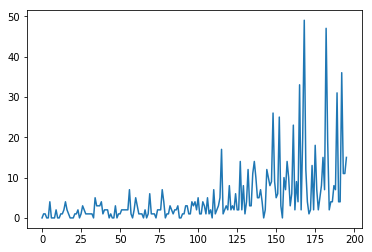

In [25]:
plt.plot(range(len(scores)),scores)

In [170]:
ag1 = Agent(env)
ag1.memory = agent.memory
ag1.LRC = 0.02

for i in range(50):
    loss = 0
    for i in range(50):
        loss += ag1.replay()
    print(loss / 50)

0.867222477198
0.641590073705
0.58120238483
0.505802779794
0.538507681191
0.515088716745
0.613125095367


KeyboardInterrupt: 

In [52]:
agent.epsilon = 0.5
agent.epsilon_min = 0.15

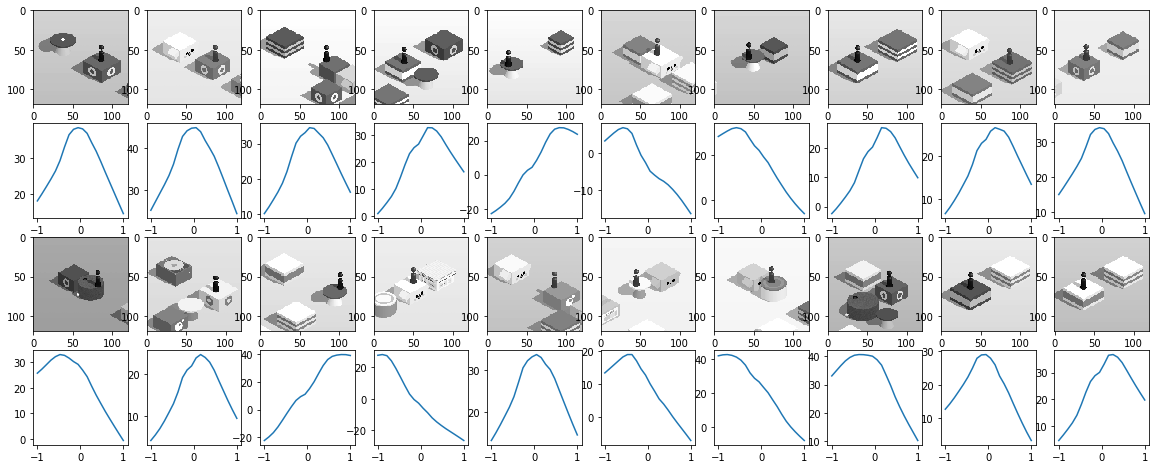

In [45]:
f, axes = plt.subplots(4,10,figsize=(20,8))

for i in range(4):
    for j in range(10):
        if i % 2 == 0:
            state = random.choice(agent.memory)[0]
            pic = state[50:170,:,0]
            axes[i][j].imshow(pic, cmap='gray')
            
            action_space = np.linspace(-1,1,20)
            reward = np.zeros_like(action_space)
            for k in range(action_space.shape[0]):
                reward[k] = agent.critic.target_model.predict_on_batch(
                    [np.expand_dims(state,0), np.expand_dims(np.expand_dims(action_space[k],0),0)])[0][0]
            axes[i+1][j].plot(action_space, reward)

In [70]:
agent.epsilon = 0.01

<Container object of 20 artists>

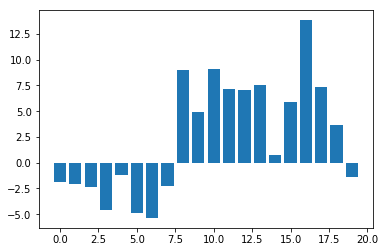

In [117]:
plt.bar(agent.env.action_space,agent.model.predict(np.expand_dims(agent.memory[][0],0))[0])

In [91]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(*args, **kwargs)
    Make a bar plot.
    
    Call signatures::
    
       bar(x, height, *, align='center', **kwargs)
       bar(x, height, width, *, align='center', **kwargs)
       bar(x, height, width, bottom, *, align='center', **kwargs)
    
    Make a bar plot with rectangles bounded by
    
    .. math::
    
       (x - width/2, x + width/2, bottom, bottom + height)
    
    (left, right, bottom and top edges) by default.  *x*,
    *height*, *width*, and *bottom* can be either scalars or
    sequences.
    
    The *align* and *orientation* kwargs control the interpretation of *x*
    and *bottom*
    
    The *align* keyword-only argument controls if *x* is interpreted
    as the center or the left edge of the rectangle.
    
    Parameters
    ----------
    x : sequence of scalars
        the x coordinates of the bars.
    
        *align* controls if *x* is the bar center (default) or
        left edge.
    
    heig

In [138]:
agent.model.save_weights('./tmp/weights.w')
pickle.dump(agent.memory, open('./tmp/memory.m','wb'))

In [68]:
min_loss = 1e10
min_pos = 0

for i in range(1000):
    loss = 0
    for i in range(50):
        l = agent.replay(32)
        loss += l
    print(loss / 50)
    
    if loss < min_loss:
        min_pos = i
        min_loss = loss
    
    if i - min_pos > 100:
        break

i

128.82689827
94.7225925446
37.4278962708
31.1282489967
15.9667807198
16.0796065235
14.0383515739
12.0921261883
11.2964262009
8.64634869099
7.35213395119
7.32252527714
6.3635424757
4.71984107256
4.57263987064
3.77086829185
4.77240906715
3.48491025209
9.52575344563
5.55766092539
4.55353834867
3.18393145323
2.79013663769
2.49263638139
3.06989862561
4.35556167364
2.88895393372
2.96023203969
3.11350908041
4.47541817427
3.99412070513


KeyboardInterrupt: 

In [58]:
i, min_pos

(228, 227)

In [178]:
agent.epsilon

0.20554993075174754